In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from EDA import *
import seaborn as sns
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
df = pd.read_csv(r'./news.csv')
df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [4]:
title = list(df['title'])
text = list(df['text'])
news = []
for i in range(len(title)):
    news.append(title[i] + '.\n' + text[i])
labels = list(df['label'])
labels = [0 if i == 'FAKE' else 1 for i in labels]
data = (news, labels)

In [5]:
from sklearn.model_selection import train_test_split

news_train, news_test, labels_train, labels_test = train_test_split(news, labels, test_size = 0.2)
train_data = (news_train, labels_train)
test_data = (news_test, labels_test)

print('train size: ', len(train_data[0]))
print('test size: ', len(test_data[0]))

train size:  5068
test size:  1267


In [6]:
# shuffle
state = np.random.get_state()
np.random.shuffle(train_data[0])
np.random.set_state(state)
np.random.shuffle(train_data[1])


state1 = np.random.get_state()
np.random.shuffle(test_data[0])
np.random.set_state(state1)
np.random.shuffle(test_data[1])

In [7]:
# tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# print(len(tokenizer.vocab))

In [9]:
# 将数据集分完词后存储到列表中
train_input_ids = []
train_attention_masks = []

n=5068

for sentence in train_data[0][:n]:
    encoded = tokenizer.encode_plus(
        text=sentence,  # the sentence to be encoded
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 128,  # maximum length of a sentence
        pad_to_max_length = True,
#         padding='max_length',  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    )
    
   
    train_input_ids.append(encoded['input_ids'])
#     print(encoded['input_ids'])
    

    train_attention_masks.append(encoded['attention_mask'])

# 将列表转换为 tensor
train_input_ids = torch.cat(train_input_ids)
train_attention_masks = torch.cat(train_attention_masks)
train_labels = torch.tensor(train_data[1][:n])
    

# # Get the input IDs and attention mask in tensor format
# input_ids = encoded['input_ids']
# attn_mask = encoded['attention_mask']

print('Original: ', train_data[0][0])
print('Token IDs:', train_input_ids[0])
print(train_labels[0])

Original:  Rachel Dolezal has a right to be black (Opinion).
On Monday, Rachel Dolezal, the head of the Spokane chapter of the NAACP, resigned in shame because she had posed as a black woman even though she is biologically white.

The outing of Dolezal seems ironic given the recent public embrace of Caitlyn Jenner, the transgender woman formerly known as Bruce Jenner. Jenner seems to have ushered in an era of greater tolerance about the constructed nature of identity. After all, when a transgender woman is elevated to the cover of Vanity Fair, it's as though we have reached a tipping point. We can accept the idea that one's social identity can be radically transformed if it doesn't match with what one feels in the heart.

The stark difference in Dolezal's treatment forces us to ask what's the difference between claiming a gender identity versus a racial identity? Why is it that we celebrate Bruce Jenner's gender change and frown upon Rachel Dolezal's racial change?

Dolezal is disturbi

In [10]:
from torch.utils.data import TensorDataset, random_split


dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)

# 计算训练集和验证集大小
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size


train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,561 training samples
  507 validation samples


In [11]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_dataloader = DataLoader(
            train_dataset, 
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size
        )


validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
        )

In [12]:
from transformers import BertForSequenceClassification, AdamW, BertConfig


model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2, 
                    
    output_attentions = False, 
    output_hidden_states = False, 
    return_dict=False
)


model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [13]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate 
                  eps = 1e-8 # args.adam_epsilon  
                )

from transformers import get_linear_schedule_with_warmup


epochs = 3


total_steps = len(train_dataloader) * epochs


scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [14]:
import numpy as np


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    
    elapsed_rounded = int(round((elapsed)))
    
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [15]:
import random
import numpy as np


seed_val = 42
batch_size = 32
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats = []


total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    
    t0 = time.time()

   
    total_train_loss = 0

    
    model.train()


    for step, batch in enumerate(train_dataloader):

       
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        
        model.zero_grad()        

        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        
        total_train_loss += loss.item()

       
        loss.backward()

       
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      
        optimizer.step()

        
        scheduler.step()

   
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================


    print("")
    print("Running Validation...")

    t0 = time.time()


    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
       
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
       
        total_eval_loss += loss.item()

        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

   
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
  
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    286.    Elapsed: 0:00:06.
  Batch    80  of    286.    Elapsed: 0:00:11.
  Batch   120  of    286.    Elapsed: 0:00:17.
  Batch   160  of    286.    Elapsed: 0:00:22.
  Batch   200  of    286.    Elapsed: 0:00:27.
  Batch   240  of    286.    Elapsed: 0:00:33.
  Batch   280  of    286.    Elapsed: 0:00:38.

  Average training loss: 0.24
  Training epcoh took: 0:00:39

Running Validation...
  Accuracy: 0.95
  Validation Loss: 0.14
  Validation took: 0:00:01

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    286.    Elapsed: 0:00:05.
  Batch    80  of    286.    Elapsed: 0:00:11.
  Batch   120  of    286.    Elapsed: 0:00:16.
  Batch   160  of    286.    Elapsed: 0:00:22.
  Batch   200  of    286.    Elapsed: 0:00:27.
  Batch   240  of    286.    Elapsed: 0:00:33.
  Batch   280  of    286.    Elapsed: 0:00:38.

  Average training loss: 0.08
  Training epcoh took: 0:00:39

Running Validation...
  Accuracy: 0.97
 

In [16]:
import pandas as pd


pd.set_option('precision', 2)


df_stats = pd.DataFrame(data=training_stats)


df_stats = df_stats.set_index('epoch')


df_stats


,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.24,0.14,0.95,0:00:39,0:00:01
2,0.08,0.11,0.97,0:00:39,0:00:01
3,0.03,0.11,0.97,0:00:39,0:00:01


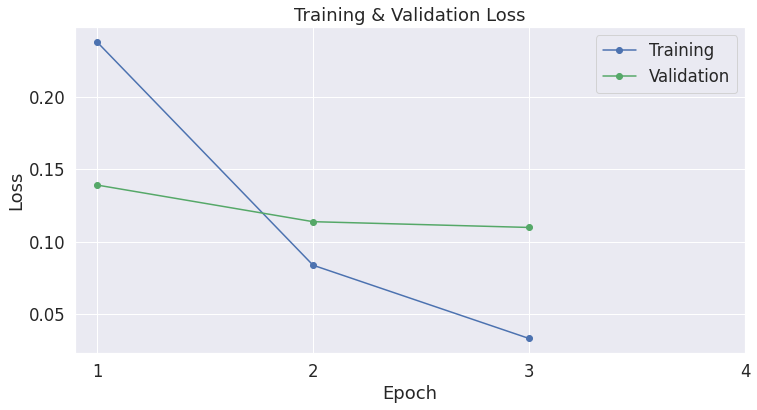

In [17]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)


plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [18]:

test_input_ids = []
test_attention_masks = []

n = 1267
for sentence in test_data[0][:n]:
    encoded = tokenizer.encode_plus(
        text=sentence,  # the sentence to be encoded
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 128,  # maximum length of a sentence
        pad_to_max_length = True,
#         padding='max_length',  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    )
  
    
    test_input_ids.append(encoded['input_ids'])
#     print(encoded['input_ids'])
  
    test_attention_masks.append(encoded['attention_mask'])


test_input_ids = torch.cat(test_input_ids)
test_attention_masks = torch.cat(test_attention_masks)
test_labels = torch.tensor(test_data[1][:n])

batch_size = 32  

prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/root/miniconda3/envs/myconda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:


print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

model.eval()

# Tracking variables 
predictions , true_labels = [], []


for batch in prediction_dataloader:
  
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

   
    with torch.no_grad():
     
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

   
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    #total_eval_accuracy += flat_accuracy(logits, label_ids)


   
    predictions.append(logits)
    true_labels.append(label_ids)
#avg_val_accuracy = flat_accuracy(predictions, true_labels)    
#avg_val_accuracy = total_eval_accuracy / len(prediction_dataloader)
#print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
print('    DONE.')

Predicting labels for 1,267 test sentences...
    DONE.


In [20]:
print('Positive samples: %d of %d (%.2f%%)' % (sum(test_data[1]), len(test_data[1]), (sum(test_data[1]) / len(test_data[1]) * 100.0)))


Positive samples: 632 of 1267 (49.88%)


In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pred_labels_i = []
# For each input batch...
for i in range(len(true_labels)):
    pred_labels_i += list(np.argmax(predictions[i], axis=1).flatten())

    
true_labels_list = []
for i in test_labels:
    true_labels_list.append(i.item())

accuracy_score(pred_labels_i, true_labels_list)

0.9731649565903709

Classification Report:
              precision    recall  f1-score   support

           1     0.9628    0.9842    0.9734       632
           0     0.9839    0.9622    0.9729       635

    accuracy                         0.9732      1267
   macro avg     0.9734    0.9732    0.9732      1267
weighted avg     0.9734    0.9732    0.9732      1267



[Text(0, 0.5, 'POS'), Text(0, 1.5, 'NEG')]

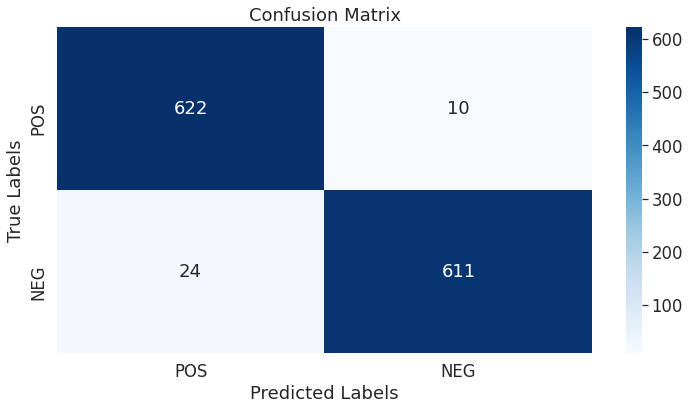

In [22]:
print('Classification Report:') 
print(classification_report(true_labels_list, pred_labels_i, labels=[1,0], digits=4)) 

cm = confusion_matrix(true_labels_list, pred_labels_i, labels=[1,0]) 
ax= plt.subplot() 
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d") 
ax.set_title('Confusion Matrix') 
ax.set_xlabel('Predicted Labels') 
ax.set_ylabel('True Labels') 
ax.xaxis.set_ticklabels(['POS', 'NEG']) 
ax.yaxis.set_ticklabels(['POS', 'NEG']) 